## The plan for the hybrid model:

1. Write in python sams hybrid model and demonstrate learning
2. Fix the tuned params as ground truth and apply stan to learn them
3. demonstrate learning using groud truth graphed with error lines
4. Try post hoc learning?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
rng = np.random.default_rng()

In [ ]:
class Bandit():
    def __init__(self, length, arms=None):
        # Starting with just dual arm bandits!
        # Usage: [(arm1_mean, arm1_std), (arm2_mean, arm2_std)]
        if arms is None:
            arms = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

        self.arms = arms
        # Create the test_set
        self.test_set = []
        for _ in range(length):
            self.test_set.append([np.random.normal(loc=mean, scale=std) for mean, std in self.arms])

    def __str__(self):
        ret = ""
        for c, arm in enumerate(self.arms):
            ret += "Arm "+str(c)+"\t Mean: "+str(arm[0])+"\tStd: "+str(arm[1])+"\n"
        return f"{ret}\nTest Set:\n{str(self.test_set)}"

In [37]:
s = [0.03125, 0.08333333,  0.08333333, 0.08333333, 0.08333333]
m =  [ 0.16099557,  0.09858405, -0.05835445, -0.0709279,  -0.08194819]
recs = np.zeros((10000, 5))
for i in range(10000):
    recs[i] = rng.normal(m, s)
np.mean(recs, axis=0)

array([ 0.16123708,  0.09809102, -0.05701851, -0.07090606, -0.08183892])

In [101]:
w=[0.5,0.5]
K=5
nTrials=100
m = np.array([1.5, 1, 0.5, -0.5, -1])
# initialise the estimated mean of each arm to 0
mhat = np.zeros(K)
# initialise estimated variance of each arm to 1
shat = 0.5*np.ones(K)
# Observation noise variance
v = 0.1
# Create regret array
regret = np.zeros(nTrials)
trial = 0

In [121]:
trial+=1
# sample from the scaled posterior
d = rng.normal(mhat, w[1]*shat)
# Add UCB bonus
ucb_bonus= w[0]*np.sqrt(shat)
action = np.argmax(d+ucb_bonus)

# Observe reward
reward = rng.normal(m[action], v)
# Calculate Regret
reg = np.max(m) - m[action]
regret[trial] = reg
# Calculate Kalman Gain
g = shat[action] / (shat[action] + v)
# Update Mean Estimate
mhat[action] = mhat[action] + g*(reward - mhat[action])
# Update Variance Estimate
shat[action] = shat[action] - g*shat[action]

print("Trial:", trial)
print("m:", m)
print("mhat:", mhat)
print("d", d)
print("g", g)
print("shat", shat)
print("reward", reward)
print("action", action)
print("reg", reg)
print("ucb bonus", ucb_bonus)

Trial: 20
m: [ 1.5  1.   0.5 -0.5 -1. ]
mhat: [1.53396335 0.         0.         0.         0.        ]
d [ 1.53643959 -0.05225475 -0.34515952  0.00449183  0.56720471]
g 0.0495049504950495
shat [0.0049505 0.5       0.5       0.5       0.5      ]
reward 1.470623259279034
action 0
reg 0.0
ucb bonus [0.03608439 0.35355339 0.35355339 0.35355339 0.35355339]


In [123]:
regret[:trial]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
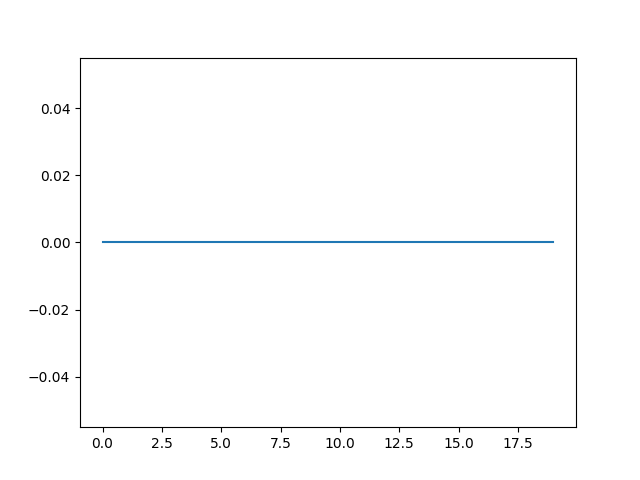

In [122]:
plt.close("all")
adapted = np.cumsum(regret[:trial])/np.arange(1,trial+1)
plt.plot(adapted)
plt.show()

In [124]:
def hybrid(w, K, nTrials, debug=False):
    # w = Weights
    # nTrials = Number of Trials
    # K = arms
    # Create the mean reward values for each arm
    m = rng.normal(0, 0.5, size=(K))
    # initialise the estimated mean of each arm to 0
    mhat = np.zeros(K)
    # initialise estimated variance of each arm to 1
    shat = 0.5*np.ones(K)
    # Observation noise variance
    v = 0.1
    # Create regret array
    regret = np.zeros(nTrials)

    for trial in range(nTrials):
        # sample from the scaled posterior
        d = rng.normal(mhat, w[1]*shat)
        # Add UCB bonus
        ucb_bonus= w[0]*np.sqrt(shat)
        action = np.argmax(d+ucb_bonus)

        # Observe reward
        reward = rng.normal(m[action], v)
        # Calculate Regret
        regret[trial] = np.max(m) - m[action]
        # Calculate Kalman Gain
        g = shat[action] / (shat[action] + v)
        # Update Mean Estimate
        mhat[action] = mhat[action] + g*(reward - mhat[action])
        # Update Variance Estimate
        shat[action] = shat[action] - g*shat[action]
        
        if debug and (trial == 99):
            print("Actual Arm Values:", m)
            print("Estimated Arm Values:", mhat)
            print("Exploration Values:", d)
            print("------------------------")
            print("best action", np.argmax(m))
            print("chosen action:", action)
            print("------------------------")
            print("highest reward", max(m))
            print("Selected reward", reward)
            print("regret", regret[trial])
        
        # posterior sampling
        #m = mvnrnd(B*m,Q)';
        # m = rng.normal(m, 0)
        

    average_regret = np.cumsum(regret)/ np.arange(1,nTrials+1)
    return average_regret

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
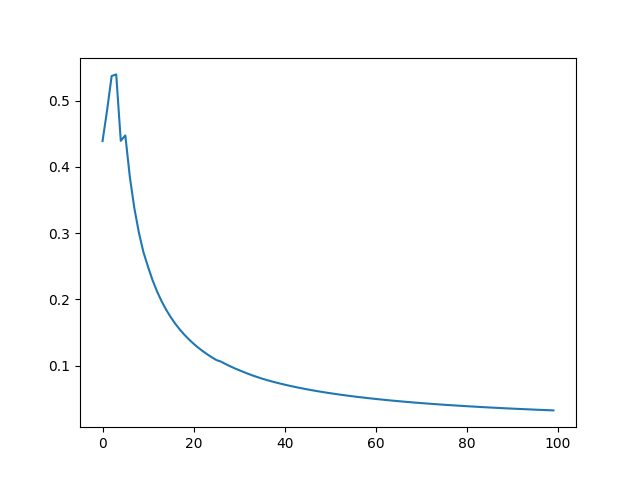

In [125]:
plt.close()
run1 = hybrid(w=[0.5,0.5], K=5, nTrials=100, debug=False)
run2 = hybrid(w=[0.5,0.5], K=5, nTrials=100, debug=False)
run3 = hybrid(w=[0.5,0.5], K=5, nTrials=100, debug=False)
run4 = hybrid(w=[0.5,0.5], K=5, nTrials=100, debug=False)
plt.plot(np.mean([run1, run2, run3, run4], axis=0))
plt.show()

In [129]:
def hybrid(w, K, nTrials, debug=False):
    # w = Weights
    # nTrials = Number of Trials
    # K = arms
    # Create the mean reward values for each arm
    m = rng.normal(0, 0.5, size=(K))
    # initialise the estimated mean of each arm to 0
    mhat = np.zeros(K)
    # initialise estimated variance of each arm to 1
    shat = 0.5*np.ones(K)
    # Observation noise variance
    v = 0.1
    # Create regret array
    regret = np.zeros(nTrials)

    for trial in range(nTrials):
        # sample from the scaled posterior
        d = rng.normal(mhat, w[1]*shat)
        # Add UCB bonus
        ucb_bonus= w[0]*np.sqrt(shat)
        action = np.argmax(d+ucb_bonus)

        # Observe reward
        reward = rng.normal(m[action], v)
        # Calculate Regret
        regret[trial] = np.max(m) - m[action]
        # Calculate Kalman Gain
        g = shat[action] / (shat[action] + v)
        # Update Mean Estimate
        mhat[action] = mhat[action] + g*(reward - mhat[action])
        # Update Variance Estimate
        shat[action] = shat[action] - g*shat[action]

    average_regret = np.cumsum(regret)/ np.arange(1,nTrials+1)
    return average_regret

In [130]:
# number of reps
nReps = 100
# number of trials
nTrials = 100
# Arms
K = 5
# Thompson, UCB, Hybrid
test_weights = {"Thompson": [1, 0], "UCB": [0, 1], "Hybrid": [0.5, 0.5]}

test_results = {"Thompson": np.zeros(nTrials), "UCB": np.zeros(nTrials), "Hybrid": np.zeros(nTrials)}

for test in test_weights.keys():
    average_regrets = np.zeros((nReps, nTrials))
    for rep in range(nReps):
        average_regrets[rep] = hybrid(w=weights[test], K=K, nTrials=nTrials)
    test_results[test] = np.mean(average_regrets, axis=0)
    
## Plotting
fig, ax = plt.subplots()
plt.title("Average Rewards")
ax.set_xlabel("Trial Number")
ax.set_ylabel("Average Regret")
for test in test_results.keys():
    ax.plot(test_results[test], label=test)
ax.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
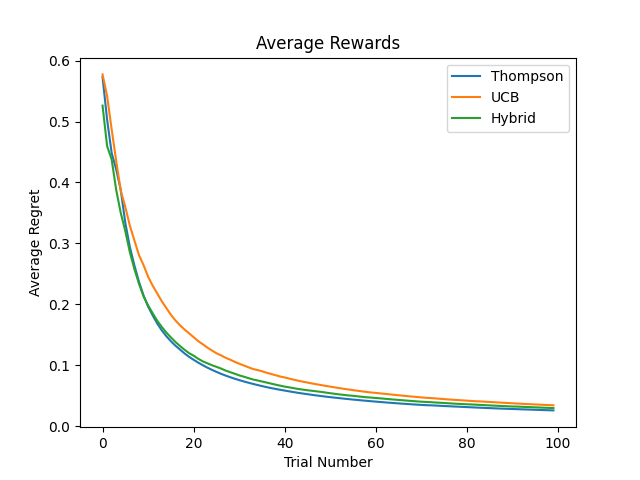

In [ ]:
plt.close("all")

In [ ]:
def __init__(self):
        self.Q = [0,0]
        self.sigma = [100,100]
        self.tau = [10, 10]
        # self.alpha = 0
        self.n = [1,1]

        # theta = 0 is entirely UCB, 1 is entirely thompson
        self.theta = 0
        self.regret = []
        
    def q_update(self, arm, reward):
        # This can be redefined later
        # Default
        # self.Q[arm] = self.Q[arm] + self.alpha*(reward - self.Q[arm])
        self.Q[arm] = self.Q[arm] + ((reward - self.Q[arm])/self.n[arm])

    def sigma_update(self, arm):
        # self.sigma[arm] = np.sqrt(pow(self.sigma[arm],2) - self.alpha*pow(self.sigma[arm],2))
        self.sigma[arm] = pow(self.tau[arm], 2)/self.n[arm]

    def alpha_update(self, arm):
        self.alpha = pow(self.sigma[arm],2)/(pow(self.sigma[arm],2) + pow(self.tau[arm], 2))

    def n_update(self, arm):
        self.n[arm] += 1

    def choice(self):
        ucb = (self.Q[0] - self.Q[1])/np.sqrt(pow(self.sigma[0], 2) + pow(self.sigma[1], 2))
        thompson = self.Q[0] - self.Q[1]
        combined = self.theta*ucb + (1 - self.theta)*thompson
        return int(np.round(sp.norm.cdf(combined)))

    def learn(self, bandit):
        for arms in bandit.test_set:
            # Choose an arm
            selected_arm = self.choice()
            best_arm = np.argmax(arms)
            # Record the regret of the choice
            regret = arms[best_arm] - arms[selected_arm]
            self.regret.append(regret)

            # Alpha update no longer needed in 
            # self.alpha_update(selected_arm)

            # Call each of the update functions
            self.q_update(selected_arm, arms[selected_arm])
            self.sigma_update(selected_arm)
            self.n_update(selected_arm)
        
        return self.Q

## Original:

In [ ]:
# This creates a default agent that can be rewritten for adaptations
class Agent():
    def __init__(self):
        self.Q = [0,0]
        self.sigma = [100,100]
        self.tau = [10, 10]
        # self.alpha = 0
        self.n = [1,1]

        # theta = 0 is entirely UCB, 1 is entirely thompson
        self.theta = 0
        self.regret = []
        
    def q_update(self, arm, reward):
        # This can be redefined later
        # Default
        # self.Q[arm] = self.Q[arm] + self.alpha*(reward - self.Q[arm])
        self.Q[arm] = self.Q[arm] + ((reward - self.Q[arm])/self.n[arm])

    def sigma_update(self, arm):
        # self.sigma[arm] = np.sqrt(pow(self.sigma[arm],2) - self.alpha*pow(self.sigma[arm],2))
        self.sigma[arm] = pow(self.tau[arm], 2)/self.n[arm]

    def alpha_update(self, arm):
        self.alpha = pow(self.sigma[arm],2)/(pow(self.sigma[arm],2) + pow(self.tau[arm], 2))

    def n_update(self, arm):
        self.n[arm] += 1

    def choice(self):
        ucb = (self.Q[0] - self.Q[1])/np.sqrt(pow(self.sigma[0], 2) + pow(self.sigma[1], 2))
        thompson = self.Q[0] - self.Q[1]
        combined = self.theta*ucb + (1 - self.theta)*thompson
        return int(np.round(sp.norm.cdf(combined)))

    def learn(self, bandit):
        for arms in bandit.test_set:
            # Choose an arm
            selected_arm = self.choice()
            best_arm = np.argmax(arms)
            # Record the regret of the choice
            regret = arms[best_arm] - arms[selected_arm]
            self.regret.append(regret)

            # Alpha update no longer needed in 
            # self.alpha_update(selected_arm)

            # Call each of the update functions
            self.q_update(selected_arm, arms[selected_arm])
            self.sigma_update(selected_arm)
            self.n_update(selected_arm)
        
        return self.Q
            
    def plot_loss(self):
        fig, ax = plt.subplots()
        ax.set(xlabel="Iteration", ylabel="Cumulative Regret", title="Model Performance")
        ax.plot(np.cumsum(self.regret))
        return ax



if __name__ == '__main__':
    b1 = Bandit(length=1000, arms=[(1, 1), (-1, 1)])
    ag = Agent()
    ag.learn(b1)
    ag.plot_loss()
    plt.show()
